In [6]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import spacy
import scispacy
import en_core_sci_sm
import math
import pickle
from pandas import ExcelWriter
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import svm
from sklearn.metrics import mean_squared_error

In [7]:
admissions = pd.read_csv('/home/ec2-user/.jupyter/MyNotebooks/dataset/unzip_dataset/ADMISSIONS.csv')
columns_main = ['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DEATHTIME']
main = admissions[columns_main]
main.loc[:,['ADMITTIME', 'DISCHTIME','DEATHTIME']] = main[['ADMITTIME', 'DISCHTIME','DEATHTIME']].apply(pd.to_datetime)

In [8]:
main.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT


In [9]:
main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   SUBJECT_ID  58976 non-null  int64         
 1   HADM_ID     58976 non-null  int64         
 2   ADMITTIME   58976 non-null  datetime64[ns]
 3   DISCHTIME   58976 non-null  datetime64[ns]
 4   DEATHTIME   5854 non-null   datetime64[ns]
dtypes: datetime64[ns](3), int64(2)
memory usage: 2.2 MB


In [10]:
main['SUBJECT_ID'].nunique()

46520

In [11]:
main['HADM_ID'].nunique()

58976

In [12]:
# 1.Numero de checkpoints/paciente en % (SUBJECT_ID) > 0... N-1, N=Numero de ingresos
#main.loc[:,'checkpoints'] = main.groupby('SUBJECT_ID')['SUBJECT_ID'].transform('cumcount')

In [13]:
main.loc[:,'checkpoints'] = main.groupby('SUBJECT_ID').cumcount()

/home/ec2-user/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ec2-user/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [14]:
main['checkpoints'] = main['checkpoints'].apply(lambda x: x+1)

<ipython-input-14-9b4f49df3eec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main['checkpoints'] = main['checkpoints'].apply(lambda x: x+1)


In [15]:
main.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,checkpoints
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,1
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,1
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,2
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,1
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,1


In [16]:
# 2.Numero de hospitalizaciones en la UCI (ICUSTAY_ID )

In [17]:
icustays = pd.read_csv('/home/ec2-user/.jupyter/MyNotebooks/dataset/unzip_dataset/ICUSTAYS.csv')
columns_icu = ['SUBJECT_ID','HADM_ID','ICUSTAY_ID']
uci = icustays[columns_icu]

In [18]:
uci.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61532 entries, 0 to 61531
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   SUBJECT_ID  61532 non-null  int64
 1   HADM_ID     61532 non-null  int64
 2   ICUSTAY_ID  61532 non-null  int64
dtypes: int64(3)
memory usage: 1.4 MB


In [19]:
uci.loc[:,'UCI_HOSP'] = uci.groupby('SUBJECT_ID').cumcount()

/home/ec2-user/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ec2-user/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [20]:
uci['UCI_HOSP'] = uci['UCI_HOSP'].apply(lambda x: x+1)

<ipython-input-20-9c3b6e11df42>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uci['UCI_HOSP'] = uci['UCI_HOSP'].apply(lambda x: x+1)


In [21]:
uci.dtypes

SUBJECT_ID    int64
HADM_ID       int64
ICUSTAY_ID    int64
UCI_HOSP      int64
dtype: object

In [22]:
# 3.Percentage of deaths

In [23]:
main['ALIVE'] = main['DEATHTIME'].apply(lambda x: 0 if (pd.isnull(x)) else 1) #0 is alive ;; 1 is death

<ipython-input-23-a7969483afcc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main['ALIVE'] = main['DEATHTIME'].apply(lambda x: 0 if (pd.isnull(x)) else 1) #0 is alive ;; 1 is death


In [24]:
main[main['SUBJECT_ID']==109]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,checkpoints,ALIVE
118,109,183350,2137-11-04 19:36:00,2137-11-21 18:13:00,NaT,1,0
119,109,128755,2138-04-16 17:44:00,2138-04-19 16:00:00,NaT,2,0
120,109,164029,2140-01-19 13:25:00,2140-01-21 13:25:00,NaT,3,0
121,109,108375,2140-02-02 02:13:00,2140-02-02 16:25:00,NaT,4,0
122,109,193281,2140-04-07 19:51:00,2140-05-02 16:30:00,NaT,5,0
123,109,175347,2140-05-17 14:27:00,2140-05-20 19:50:00,NaT,6,0
124,109,110668,2140-08-25 14:39:00,2140-09-02 18:30:00,NaT,7,0
125,109,166018,2141-03-27 21:08:00,2141-03-28 17:45:00,NaT,8,0
126,109,170149,2141-05-24 14:47:00,2141-06-06 19:55:00,NaT,9,0
127,109,147469,2141-06-11 10:17:00,2141-06-17 16:29:00,NaT,10,0


In [25]:
#Severity is classified as “low” if alive is 0 and UCI_HOSP<3 including NaN, regardless number of checkpoints

In [26]:
#Severity is classified as “high” if alive is 1 or if alive is 0 and UCI_HOSP>=3, regardless number of checkpoints

In [27]:
master_severity = pd.merge(main, uci, how='left', on=['SUBJECT_ID', 'HADM_ID'])

In [28]:
master_severity[master_severity['UCI_HOSP'].isnull()] #los que no hayan estado en la UCI deberian ser 0 en lugar de NaN

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,checkpoints,ALIVE,ICUSTAY_ID,UCI_HOSP
91,84,120969,2196-02-02 07:15:00,2196-02-04 17:48:00,NaT,1,0,NaN,NaN
151,135,199634,2174-05-17 09:00:00,2174-05-21 14:00:00,NaT,2,0,NaN,NaN
243,299,175259,2176-06-26 10:45:00,2176-06-29 17:30:00,NaT,1,0,NaN,NaN
285,330,184134,2132-01-15 07:15:00,2132-01-17 10:30:00,NaT,1,0,NaN,NaN
311,352,152913,2145-04-07 03:32:00,2145-04-14 13:19:00,NaT,2,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
62593,90688,127169,2154-05-16 07:15:00,2154-05-16 16:15:00,NaT,3,0,NaN,NaN
62633,95377,103529,2190-09-08 07:15:00,2190-09-08 22:40:00,NaT,2,0,NaN,NaN
62693,98744,116892,2127-06-27 13:30:00,2127-06-27 20:00:00,NaT,4,0,NaN,NaN
62707,98761,184477,2186-01-16 10:30:00,2186-01-16 16:30:00,NaT,1,0,NaN,NaN


In [29]:
master_severity['UCI_HOSP'] = master_severity['UCI_HOSP'].apply(lambda x: 0 if (pd.isnull(x)) else x) 

In [30]:
master_severity['ICUSTAY_ID'] = master_severity['ICUSTAY_ID'].apply(lambda x: 0 if (pd.isnull(x)) else x) 

In [31]:
master_severity.dtypes

SUBJECT_ID              int64
HADM_ID                 int64
ADMITTIME      datetime64[ns]
DISCHTIME      datetime64[ns]
DEATHTIME      datetime64[ns]
checkpoints             int64
ALIVE                   int64
ICUSTAY_ID            float64
UCI_HOSP              float64
dtype: object

In [32]:
master_severity['ICUSTAY_ID'] = master_severity['ICUSTAY_ID'].astype(np.int64)

In [33]:
master_severity['UCI_HOSP'] = master_severity['UCI_HOSP'].astype(np.int64)

In [34]:
master_severity.dtypes

SUBJECT_ID              int64
HADM_ID                 int64
ADMITTIME      datetime64[ns]
DISCHTIME      datetime64[ns]
DEATHTIME      datetime64[ns]
checkpoints             int64
ALIVE                   int64
ICUSTAY_ID              int64
UCI_HOSP                int64
dtype: object

In [35]:
#master_severity['UCI_HOSP'] = master_severity['UCI_HOSP'].astype(np.int64)

In [36]:
master_severity[master_severity['SUBJECT_ID']==84]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,checkpoints,ALIVE,ICUSTAY_ID,UCI_HOSP
91,84,120969,2196-02-02 07:15:00,2196-02-04 17:48:00,NaT,1,0,0,0
92,84,166401,2196-04-14 04:02:00,2196-04-17 13:42:00,2196-04-17 13:42:00,2,1,239661,1


In [37]:
master_severity.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,checkpoints,ALIVE,ICUSTAY_ID,UCI_HOSP
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,1,0,204798,1
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,1,0,227807,1
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,2,0,234044,2
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,1,0,262236,1
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,1,0,203487,1


In [38]:
master_severity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62722 entries, 0 to 62721
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   SUBJECT_ID   62722 non-null  int64         
 1   HADM_ID      62722 non-null  int64         
 2   ADMITTIME    62722 non-null  datetime64[ns]
 3   DISCHTIME    62722 non-null  datetime64[ns]
 4   DEATHTIME    6650 non-null   datetime64[ns]
 5   checkpoints  62722 non-null  int64         
 6   ALIVE        62722 non-null  int64         
 7   ICUSTAY_ID   62722 non-null  int64         
 8   UCI_HOSP     62722 non-null  int64         
dtypes: datetime64[ns](3), int64(6)
memory usage: 4.8 MB


In [39]:
master_severity['SEVERITY'] = master_severity[['UCI_HOSP','ALIVE']].\
apply(lambda x: 0 if ((x['UCI_HOSP']<3) and x['ALIVE']==0) else 1, axis=1) #0 is LOW, 1 is HIGH

In [40]:
master_severity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62722 entries, 0 to 62721
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   SUBJECT_ID   62722 non-null  int64         
 1   HADM_ID      62722 non-null  int64         
 2   ADMITTIME    62722 non-null  datetime64[ns]
 3   DISCHTIME    62722 non-null  datetime64[ns]
 4   DEATHTIME    6650 non-null   datetime64[ns]
 5   checkpoints  62722 non-null  int64         
 6   ALIVE        62722 non-null  int64         
 7   ICUSTAY_ID   62722 non-null  int64         
 8   UCI_HOSP     62722 non-null  int64         
 9   SEVERITY     62722 non-null  int64         
dtypes: datetime64[ns](3), int64(7)
memory usage: 5.3 MB


In [41]:
master_severity[master_severity['SEVERITY']==0]['HADM_ID'].count() #50661

50661

In [42]:
master_severity[master_severity['SUBJECT_ID']==84]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,checkpoints,ALIVE,ICUSTAY_ID,UCI_HOSP,SEVERITY
91,84,120969,2196-02-02 07:15:00,2196-02-04 17:48:00,NaT,1,0,0,0,0
92,84,166401,2196-04-14 04:02:00,2196-04-17 13:42:00,2196-04-17 13:42:00,2,1,239661,1,1


In [43]:
master_severity[master_severity['SUBJECT_ID']==109] #en un mismo ingreso, se dio de alta en la UCI 3 veces

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,checkpoints,ALIVE,ICUSTAY_ID,UCI_HOSP,SEVERITY
123,109,183350,2137-11-04 19:36:00,2137-11-21 18:13:00,NaT,1,0,277062,1,0
124,109,183350,2137-11-04 19:36:00,2137-11-21 18:13:00,NaT,1,0,298630,2,0
125,109,183350,2137-11-04 19:36:00,2137-11-21 18:13:00,NaT,1,0,208379,3,1
126,109,128755,2138-04-16 17:44:00,2138-04-19 16:00:00,NaT,2,0,271885,4,1
127,109,164029,2140-01-19 13:25:00,2140-01-21 13:25:00,NaT,3,0,290868,5,1
128,109,108375,2140-02-02 02:13:00,2140-02-02 16:25:00,NaT,4,0,257698,6,1
129,109,193281,2140-04-07 19:51:00,2140-05-02 16:30:00,NaT,5,0,243688,7,1
130,109,175347,2140-05-17 14:27:00,2140-05-20 19:50:00,NaT,6,0,231823,8,1
131,109,110668,2140-08-25 14:39:00,2140-09-02 18:30:00,NaT,7,0,221610,9,1
132,109,166018,2141-03-27 21:08:00,2141-03-28 17:45:00,NaT,8,0,241668,10,1


In [44]:
fl = open("master_severity.pkl", "wb")
pickle.dump(master_severity, fl)
fl.close()

In [45]:
main[main['DISCHTIME'].isnull()] #no hay pacientes actualmente hospitalizados. A todos les han dado el alta o han fallecido.

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,checkpoints,ALIVE


In [46]:
## Time between rehosp

In [47]:
main = main.sort_values(['SUBJECT_ID','checkpoints'], ascending= False)

In [48]:
main.loc[:,'max_checkpoints'] = main.groupby('SUBJECT_ID')['HADM_ID'].transform('count')

In [49]:
main['REHOSP'] = main['ADMITTIME'].shift() - main['DISCHTIME']

In [50]:
main['REHOSP'] = main['REHOSP'] / np.timedelta64(1, 'D')

In [51]:
main['REHOSP'] = main[['checkpoints','max_checkpoints','REHOSP']].\
apply(lambda x: 0 if ((x['checkpoints']==x['max_checkpoints']) or pd.isnull(x['REHOSP'])) else x['REHOSP'], axis=1)

In [52]:
main[main['REHOSP'].isnull()]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,checkpoints,ALIVE,max_checkpoints,REHOSP


In [53]:
del main['max_checkpoints']

In [54]:
main.head(10)

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,checkpoints,ALIVE,REHOSP
56566,99999,113369,2117-12-30 07:15:00,2118-01-04 16:30:00,NaT,1,0,0.000000
56565,99995,137810,2147-02-08 08:00:00,2147-02-11 13:15:00,NaT,1,0,0.000000
56437,99992,197084,2144-07-25 18:03:00,2144-07-28 17:56:00,NaT,1,0,0.000000
56436,99991,151118,2184-12-24 08:30:00,2185-01-05 12:15:00,NaT,1,0,0.000000
56435,99985,176670,2181-01-27 02:47:00,2181-02-12 17:05:00,NaT,1,0,0.000000
56434,99983,117390,2193-04-26 11:35:00,2193-04-29 13:30:00,NaT,1,0,0.000000
56433,99982,183791,2157-02-16 17:31:00,2157-02-22 20:36:00,NaT,3,0,0.000000
56432,99982,112748,2157-01-05 17:27:00,2157-01-12 13:00:00,NaT,2,0,35.188194
56431,99982,151454,2156-11-28 11:56:00,2156-12-08 13:45:00,NaT,1,0,28.154167
56430,99973,150202,2180-11-27 02:30:00,2180-12-01 13:42:00,NaT,1,0,0.000000


In [55]:
main[main['SUBJECT_ID']==109].head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,checkpoints,ALIVE,REHOSP
193,109,189332,2142-08-28 19:48:00,2142-08-30 15:20:00,2142-08-30 15:20:00,34,1,0.000000
192,109,155726,2142-08-13 04:03:00,2142-08-16 18:17:00,NaT,33,0,12.063194
191,109,196721,2142-07-12 15:27:00,2142-07-23 18:41:00,NaT,32,0,20.390278
190,109,131376,2142-07-07 10:01:00,2142-07-08 18:05:00,NaT,31,0,3.890278
189,109,174489,2142-07-03 14:48:00,2142-07-04 17:23:00,NaT,30,0,2.693056


In [56]:
main['HADM_ID'].nunique()

58976

In [57]:
fl = open("main.pkl", "wb")
pickle.dump(main, fl)
fl.close()

In [58]:
master = pd.merge(master_severity, main, how='left', on=['SUBJECT_ID', 'HADM_ID','ADMITTIME','DISCHTIME','DEATHTIME','checkpoints','ALIVE'])

In [59]:
fl = open("master.pkl", "wb")
pickle.dump(master, fl)
fl.close()

In [60]:
master.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,checkpoints,ALIVE,ICUSTAY_ID,UCI_HOSP,SEVERITY,REHOSP
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,1,0,204798,1,0,0.000000
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,1,0,227807,1,0,1501.016667
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,2,0,234044,2,0,0.000000
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,1,0,262236,1,0,0.000000
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,1,0,203487,1,0,0.000000


In [61]:
master109=master[master['SUBJECT_ID']==109]

In [62]:
from pandas import ExcelWriter

writer = ExcelWriter('master_v6.xlsx')
master.head(1000).to_excel(writer,'Sheet1')
writer.save()

In [63]:
from pandas import ExcelWriter

writer = ExcelWriter('master109.xlsx')
master109.to_excel(writer,'Sheet1')
writer.save()

In [64]:
master['HADM_ID'].nunique()

58976

In [65]:
master[master['SEVERITY']==0]['HADM_ID'].count()

50661

In [66]:
master[master['SEVERITY']==1]['HADM_ID'].count()

12061

In [67]:
master[master['UCI_HOSP']==0]['HADM_ID'].count()

1190

In [68]:
master.loc[master['REHOSP']==0]['HADM_ID'].count()

49339

In [69]:
master.loc[(master['REHOSP']==0) & (master['ALIVE']==1)]['HADM_ID'].count()

6584

In [70]:
master.loc[master['REHOSP']!=0]['HADM_ID'].count()

13383

In [71]:
master.loc[(master['REHOSP']!=0) & (master['ALIVE']==1)]['HADM_ID'].count()

66

In [72]:
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62722 entries, 0 to 62721
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   SUBJECT_ID   62722 non-null  int64         
 1   HADM_ID      62722 non-null  int64         
 2   ADMITTIME    62722 non-null  datetime64[ns]
 3   DISCHTIME    62722 non-null  datetime64[ns]
 4   DEATHTIME    6650 non-null   datetime64[ns]
 5   checkpoints  62722 non-null  int64         
 6   ALIVE        62722 non-null  int64         
 7   ICUSTAY_ID   62722 non-null  int64         
 8   UCI_HOSP     62722 non-null  int64         
 9   SEVERITY     62722 non-null  int64         
 10  REHOSP       62722 non-null  float64       
dtypes: datetime64[ns](3), float64(1), int64(7)
memory usage: 5.7 MB


In [73]:
main[main['SUBJECT_ID']==84]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,checkpoints,ALIVE,REHOSP
88,84,166401,2196-04-14 04:02:00,2196-04-17 13:42:00,2196-04-17 13:42:00,2,1,0.000000
87,84,120969,2196-02-02 07:15:00,2196-02-04 17:48:00,NaT,1,0,69.426389


In [74]:
master_severity[master_severity['SUBJECT_ID']==84]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,checkpoints,ALIVE,ICUSTAY_ID,UCI_HOSP,SEVERITY
91,84,120969,2196-02-02 07:15:00,2196-02-04 17:48:00,NaT,1,0,0,0,0
92,84,166401,2196-04-14 04:02:00,2196-04-17 13:42:00,2196-04-17 13:42:00,2,1,239661,1,1


In [75]:
master[master['SUBJECT_ID']==84]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,checkpoints,ALIVE,ICUSTAY_ID,UCI_HOSP,SEVERITY,REHOSP
91,84,120969,2196-02-02 07:15:00,2196-02-04 17:48:00,NaT,1,0,0,0,0,69.426389
92,84,166401,2196-04-14 04:02:00,2196-04-17 13:42:00,2196-04-17 13:42:00,2,1,239661,1,1,0.000000


In [76]:
master.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,checkpoints,ALIVE,ICUSTAY_ID,UCI_HOSP,SEVERITY,REHOSP
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,1,0,204798,1,0,0.000000
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,1,0,227807,1,0,1501.016667
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,2,0,234044,2,0,0.000000
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,1,0,262236,1,0,0.000000
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,1,0,203487,1,0,0.000000


In [77]:
dia_icd = pd.read_csv('/home/ec2-user/.jupyter/MyNotebooks/dataset/unzip_dataset/DIAGNOSES_ICD.csv')
columns_diaicd = ['SUBJECT_ID','HADM_ID','ICD9_CODE']
dia_icd=dia_icd[columns_diaicd]

In [78]:
dia_icd['ICD9_CODE'].nunique()

6984

In [79]:
dia_icd['ICD9_CODE'].describe()

count     651000
unique      6984
top         4019
freq       20703
Name: ICD9_CODE, dtype: object

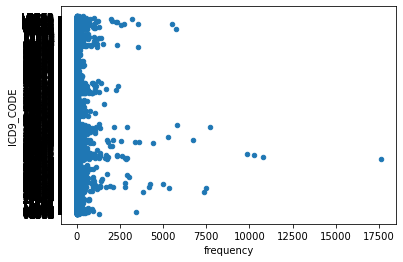

In [80]:
counts=dia_icd.groupby('ICD9_CODE')['SUBJECT_ID'].nunique()[dia_icd.groupby('ICD9_CODE')['SUBJECT_ID'].nunique()>1]
df_counts=pd.DataFrame(counts)
df_counts.rename(columns={'SUBJECT_ID':'frequency'}, inplace=True)
df_counts.reset_index(level=0, inplace=True)
df_counts.plot(x ='frequency', y='ICD9_CODE', kind = 'scatter')
plt.show()

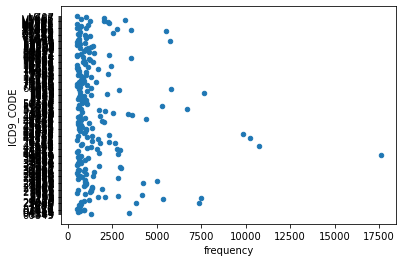

In [81]:
counts=dia_icd.groupby('ICD9_CODE')['SUBJECT_ID'].nunique()[dia_icd.groupby('ICD9_CODE')['SUBJECT_ID'].nunique()>500]
df_counts=pd.DataFrame(counts)
df_counts.rename(columns={'SUBJECT_ID':'frequency'}, inplace=True)
df_counts.reset_index(level=0, inplace=True)
df_counts.plot(x ='frequency', y='ICD9_CODE', kind = 'scatter')
plt.show()

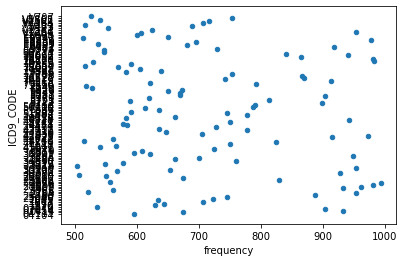

In [82]:
counts=dia_icd.groupby('ICD9_CODE')['SUBJECT_ID'].nunique()[(dia_icd.groupby('ICD9_CODE')['SUBJECT_ID'].nunique()>500) & (dia_icd.groupby('ICD9_CODE')['SUBJECT_ID'].nunique()<1000)]
df_counts=pd.DataFrame(counts)
df_counts.rename(columns={'SUBJECT_ID':'frequency'}, inplace=True)
df_counts.reset_index(level=0, inplace=True)
df_counts.plot(x ='frequency', y='ICD9_CODE', kind = 'scatter')
plt.show()

In [83]:
codes = df_counts['ICD9_CODE']

In [84]:
dia_icd['ICD9_CODE'] = np.where(dia_icd['ICD9_CODE'].isin(codes),dia_icd['ICD9_CODE'],'Others')

In [85]:
dia_icd=dia_icd.drop_duplicates(subset=['HADM_ID', 'ICD9_CODE'], keep='last')

Se han perdido el 29.5% de pacientes con una enfermedad concreta pero se ha reducido en un 98.32% el numero de enfermedades posibles (excluyendo Others). Los pacientes de AR se conservan.

In [86]:
dia_icd['SUBJECT_ID'].nunique()

46520

In [87]:
dia_icd[dia_icd['ICD9_CODE']!='Others']['SUBJECT_ID'].nunique()

32786

In [88]:
codes117_patients=dia_icd[dia_icd['ICD9_CODE']!='Others']['SUBJECT_ID']

In [89]:
dia_icd[dia_icd['ICD9_CODE']=='7140']['SUBJECT_ID'].nunique()

518

In [90]:
dia_icd['ICD9_CODE'].nunique()

118

In [91]:
fl = open("dia_icd.pkl", "wb")
pickle.dump(dia_icd, fl)
fl.close()

In [92]:
prescriptions = pd.read_csv('/home/ec2-user/.jupyter/MyNotebooks/dataset/unzip_dataset/PRESCRIPTIONS.csv', low_memory=False)
columns_prescr = ['SUBJECT_ID','HADM_ID','DRUG']
prescriptions = prescriptions[columns_prescr]

In [93]:
prescriptions.head()

,SUBJECT_ID,HADM_ID,DRUG
0,6,107064,Tacrolimus
1,6,107064,Warfarin
2,6,107064,Heparin Sodium
3,6,107064,D5W
4,6,107064,Furosemide


In [94]:
prescriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4156450 entries, 0 to 4156449
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   SUBJECT_ID  int64 
 1   HADM_ID     int64 
 2   DRUG        object
dtypes: int64(2), object(1)
memory usage: 95.1+ MB


In [95]:
#Si un paciente no tiene codigo de los 117, sus drugs son Others.

In [96]:
prescriptions['DRUG'] = np.where(prescriptions['SUBJECT_ID'].isin(codes117_patients),prescriptions['DRUG'],'Others')

In [97]:
prescriptions['DRUG'].nunique()

4220

In [98]:
#Ahora, dentro de los pacientes con 117, que puedan tener Others, sus drugs se eligen.

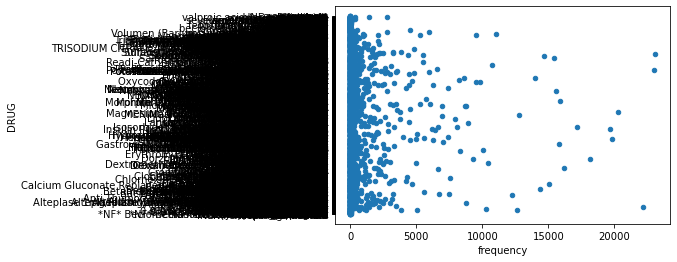

In [99]:
pcounts=prescriptions.groupby('DRUG')['SUBJECT_ID'].nunique()[prescriptions.groupby('DRUG')['SUBJECT_ID'].nunique()>1]
df_pcounts=pd.DataFrame(pcounts)
df_pcounts.rename(columns={'SUBJECT_ID':'frequency'}, inplace=True)
df_pcounts.reset_index(level=0, inplace=True)
df_pcounts.plot(x ='frequency', y='DRUG', kind = 'scatter')
plt.show()

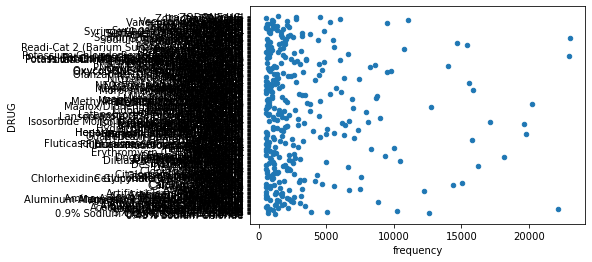

In [100]:
pcounts=prescriptions.groupby('DRUG')['SUBJECT_ID'].nunique()[prescriptions.groupby('DRUG')['SUBJECT_ID'].nunique()>500]
df_pcounts=pd.DataFrame(pcounts)
df_pcounts.rename(columns={'SUBJECT_ID':'frequency'}, inplace=True)
df_pcounts.reset_index(level=0, inplace=True)
df_pcounts.plot(x ='frequency', y='DRUG', kind = 'scatter')
plt.show()

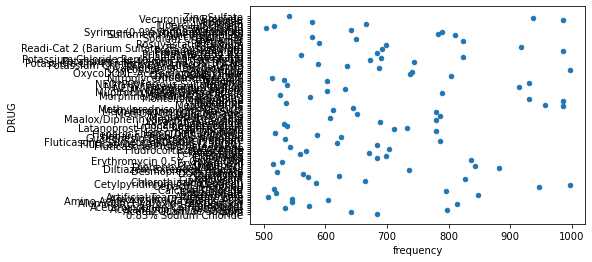

In [101]:
pcounts=prescriptions.groupby('DRUG')['SUBJECT_ID'].nunique()[(prescriptions.groupby('DRUG')['SUBJECT_ID'].nunique()>500) & (prescriptions.groupby('DRUG')['SUBJECT_ID'].nunique()<1000)]
df_pcounts=pd.DataFrame(pcounts)
df_pcounts.rename(columns={'SUBJECT_ID':'frequency'}, inplace=True)
df_pcounts.reset_index(level=0, inplace=True)
df_pcounts.plot(x ='frequency', y='DRUG', kind = 'scatter')
plt.show()

In [102]:
drugs = df_pcounts['DRUG']

Se ha reducido en un 97.5% el numero de medicamentos administrados posibles (excluyendo Others).

In [103]:
prescriptions = prescriptions[prescriptions['DRUG'].isin(drugs)]

In [104]:
prescriptions=prescriptions.drop_duplicates(subset=['HADM_ID', 'DRUG'], keep='last')

In [105]:
prescriptions['DRUG'].nunique() #De 4220 drugs, nos hemos quedado con 104.

104

In [106]:
fl = open("prescriptions.pkl", "wb")
pickle.dump(prescriptions, fl)
fl.close()

In [107]:
treatment = pd.merge(dia_icd, prescriptions, how='left', on=['SUBJECT_ID', 'HADM_ID'])

In [108]:
treatment['DRUG'] = np.where(pd.isnull(treatment['DRUG']),'Others',treatment['DRUG'])

In [109]:
treatment=treatment.drop_duplicates(subset=['HADM_ID','ICD9_CODE', 'DRUG'], keep='last')

In [110]:
treatment[treatment['ICD9_CODE']=='7140']['SUBJECT_ID'].nunique()

518

In [111]:
treatment['DRUG'].nunique()

105

In [112]:
treatment['SUBJECT_ID'].nunique()

46520

In [113]:
master['SUBJECT_ID'].nunique()

46520

## One-Hot simplificado

In [114]:
master.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,checkpoints,ALIVE,ICUSTAY_ID,UCI_HOSP,SEVERITY,REHOSP
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,1,0,204798,1,0,0.000000
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,1,0,227807,1,0,1501.016667
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,2,0,234044,2,0,0.000000
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,1,0,262236,1,0,0.000000
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,1,0,203487,1,0,0.000000


In [115]:
master['HADM_ID'].nunique()

58976

In [116]:
treatment.head()

,SUBJECT_ID,HADM_ID,ICD9_CODE,DRUG
0,109,172335,28529,Morphine Sulfate IR
1,109,172335,28529,Aztreonam
2,109,172335,Others,Morphine Sulfate IR
3,109,172335,Others,Aztreonam
4,109,173633,33829,Others


In [117]:
treatment['HADM_ID'].nunique()

58976

In [118]:
le = LabelEncoder()

In [119]:
treatment['ICD9_CODE'] = le.fit_transform(treatment['ICD9_CODE'])

In [120]:
treatment.head()

,SUBJECT_ID,HADM_ID,ICD9_CODE,DRUG
0,109,172335,17,Morphine Sulfate IR
1,109,172335,17,Aztreonam
2,109,172335,105,Morphine Sulfate IR
3,109,172335,105,Aztreonam
4,109,173633,30,Others


In [121]:
treatment[treatment['SUBJECT_ID']==109]['ICD9_CODE'].unique()

array([ 17, 105,  30,  93,  31,  64,  61,  92, 108,  24,  14, 110,  19,
       116,  99,  90,  94,   0,  53,  62])

In [122]:
treatment[treatment['SUBJECT_ID']==109]['ICD9_CODE'].nunique()

20

In [123]:
treatment_encodecode = pd.get_dummies(treatment['ICD9_CODE'], prefix='CODE')

In [124]:
treatment = treatment.join(treatment_encodecode)

In [125]:
treatment = treatment.drop('ICD9_CODE', axis=1)

In [126]:
treatment.head()

,SUBJECT_ID,HADM_ID,DRUG,CODE_0,CODE_1,CODE_2,CODE_3,CODE_4,CODE_5,CODE_6,...,CODE_108,CODE_109,CODE_110,CODE_111,CODE_112,CODE_113,CODE_114,CODE_115,CODE_116,CODE_117
0,109,172335,Morphine Sulfate IR,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,109,172335,Aztreonam,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,109,172335,Morphine Sulfate IR,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,109,172335,Aztreonam,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,109,173633,Others,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [127]:
led = LabelEncoder()

In [128]:
treatment['DRUG'] = led.fit_transform(treatment['DRUG'])

In [129]:
treatment.head()

,SUBJECT_ID,HADM_ID,DRUG,CODE_0,CODE_1,CODE_2,CODE_3,CODE_4,CODE_5,CODE_6,...,CODE_108,CODE_109,CODE_110,CODE_111,CODE_112,CODE_113,CODE_114,CODE_115,CODE_116,CODE_117
0,109,172335,63,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,109,172335,11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,109,172335,63,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,109,172335,11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,109,173633,73,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [130]:
treatment[treatment['SUBJECT_ID']==109]

,SUBJECT_ID,HADM_ID,DRUG,CODE_0,CODE_1,CODE_2,CODE_3,CODE_4,CODE_5,CODE_6,...,CODE_108,CODE_109,CODE_110,CODE_111,CODE_112,CODE_113,CODE_114,CODE_115,CODE_116,CODE_117
0,109,172335,63,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,109,172335,11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,109,172335,63,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,109,172335,11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,109,173633,73,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,109,126055,47,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1299,109,126055,100,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1300,109,126055,23,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1301,109,126055,63,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
treatment[treatment['SUBJECT_ID']==109]['DRUG'].unique()

array([ 63,  11,  73,  47, 100,  23,  71,  46,  16,  92,  20,  41,   5,
        72, 102,  43,  77,  55,  76,  65,  57,  86,   7])

In [132]:
treatment[treatment['SUBJECT_ID']==109]['DRUG'].nunique()

23

In [133]:
treatment_encodedrug = pd.get_dummies(treatment['DRUG'], prefix='DRUG')

In [134]:
treatment = treatment.join(treatment_encodedrug)

In [135]:
treatment = treatment.drop('DRUG', axis=1)

In [136]:
treatment.head()

,SUBJECT_ID,HADM_ID,CODE_0,CODE_1,CODE_2,CODE_3,CODE_4,CODE_5,CODE_6,CODE_7,...,DRUG_95,DRUG_96,DRUG_97,DRUG_98,DRUG_99,DRUG_100,DRUG_101,DRUG_102,DRUG_103,DRUG_104
0,109,172335,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,109,172335,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,109,172335,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,109,172335,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,109,173633,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [137]:
treatment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327074 entries, 0 to 327073
Columns: 225 entries, SUBJECT_ID to DRUG_104
dtypes: int64(2), uint8(223)
memory usage: 87.0 MB


In [138]:
#groupBy sumando filas menos subject_id y hadm_id > drop duplicates implicito > Los 0 se quedan en 0. Lo que no son 0 a 1.

In [139]:
treatment=treatment.groupby(['SUBJECT_ID', 'HADM_ID'])[treatment.columns[2:225]].apply(lambda x : x.sum())

In [140]:
treatment.info() #SUBJECT_ID & HADM_ID are now row index

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 58976 entries, (2, 163353) to (99999, 113369)
Columns: 223 entries, CODE_0 to DRUG_104
dtypes: int64(223)
memory usage: 101.6 MB


In [141]:
treatment.head()

,,CODE_0,CODE_1,CODE_2,CODE_3,CODE_4,CODE_5,CODE_6,CODE_7,CODE_8,CODE_9,...,DRUG_95,DRUG_96,DRUG_97,DRUG_98,DRUG_99,DRUG_100,DRUG_101,DRUG_102,DRUG_103,DRUG_104
SUBJECT_ID,HADM_ID,,,,,,,,,,,,,,,,,,,,,
2,163353,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,145834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,185777,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,178980,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,107064,0,0,0,0,0,0,0,0,0,0,...,2,0,0,2,0,0,0,0,0,0


In [142]:
treatment[treatment!=0]=1

In [143]:
treatment.head()

,,CODE_0,CODE_1,CODE_2,CODE_3,CODE_4,CODE_5,CODE_6,CODE_7,CODE_8,CODE_9,...,DRUG_95,DRUG_96,DRUG_97,DRUG_98,DRUG_99,DRUG_100,DRUG_101,DRUG_102,DRUG_103,DRUG_104
SUBJECT_ID,HADM_ID,,,,,,,,,,,,,,,,,,,,,
2,163353,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,145834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,185777,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,178980,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,107064,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [144]:
treatment.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 58976 entries, (2, 163353) to (99999, 113369)
Columns: 223 entries, CODE_0 to DRUG_104
dtypes: int64(223)
memory usage: 101.6 MB


In [145]:
treatment['SUM']=treatment[treatment.columns].apply(lambda x : x.sum(), axis=1)

In [146]:
treatment[treatment['SUM']==0] #No hay fila sin codigo o medicamento

,,CODE_0,CODE_1,CODE_2,CODE_3,CODE_4,CODE_5,CODE_6,CODE_7,CODE_8,CODE_9,...,DRUG_96,DRUG_97,DRUG_98,DRUG_99,DRUG_100,DRUG_101,DRUG_102,DRUG_103,DRUG_104,SUM
SUBJECT_ID,HADM_ID,,,,,,,,,,,,,,,,,,,,,


In [147]:
treatment[treatment['SUM']==1] #No hay fila que no tenga al menos un codigo o un medicamento,
#aunque puede ser que haya dos codigos o 2 medicamentos. Vamos a verlo por separado:

,,CODE_0,CODE_1,CODE_2,CODE_3,CODE_4,CODE_5,CODE_6,CODE_7,CODE_8,CODE_9,...,DRUG_96,DRUG_97,DRUG_98,DRUG_99,DRUG_100,DRUG_101,DRUG_102,DRUG_103,DRUG_104,SUM
SUBJECT_ID,HADM_ID,,,,,,,,,,,,,,,,,,,,,


In [148]:
treatment.columns[0:118]

Index(['CODE_0', 'CODE_1', 'CODE_2', 'CODE_3', 'CODE_4', 'CODE_5', 'CODE_6',
       'CODE_7', 'CODE_8', 'CODE_9',
       ...
       'CODE_108', 'CODE_109', 'CODE_110', 'CODE_111', 'CODE_112', 'CODE_113',
       'CODE_114', 'CODE_115', 'CODE_116', 'CODE_117'],
      dtype='object', length=118)

In [149]:
treatment.columns[118:223]

Index(['DRUG_0', 'DRUG_1', 'DRUG_2', 'DRUG_3', 'DRUG_4', 'DRUG_5', 'DRUG_6',
       'DRUG_7', 'DRUG_8', 'DRUG_9',
       ...
       'DRUG_95', 'DRUG_96', 'DRUG_97', 'DRUG_98', 'DRUG_99', 'DRUG_100',
       'DRUG_101', 'DRUG_102', 'DRUG_103', 'DRUG_104'],
      dtype='object', length=105)

In [150]:
treatment['SUM_CODES']=treatment[treatment.columns[0:118]].apply(lambda x : x.sum(), axis=1)

In [151]:
treatment['SUM_DRUGS']=treatment[treatment.columns[118:223]].apply(lambda x : x.sum(), axis=1)

In [152]:
treatment.head()

,,CODE_0,CODE_1,CODE_2,CODE_3,CODE_4,CODE_5,CODE_6,CODE_7,CODE_8,CODE_9,...,DRUG_98,DRUG_99,DRUG_100,DRUG_101,DRUG_102,DRUG_103,DRUG_104,SUM,SUM_CODES,SUM_DRUGS
SUBJECT_ID,HADM_ID,,,,,,,,,,,,,,,,,,,,,
2,163353,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,1,1
3,145834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,3,1
4,185777,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,4,1
5,178980,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,1,1
6,107064,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,6,2,4


In [153]:
treatment[treatment['SUM_CODES']==0]

,,CODE_0,CODE_1,CODE_2,CODE_3,CODE_4,CODE_5,CODE_6,CODE_7,CODE_8,CODE_9,...,DRUG_98,DRUG_99,DRUG_100,DRUG_101,DRUG_102,DRUG_103,DRUG_104,SUM,SUM_CODES,SUM_DRUGS
SUBJECT_ID,HADM_ID,,,,,,,,,,,,,,,,,,,,,


In [154]:
treatment[treatment['SUM_DRUGS']==0]

,,CODE_0,CODE_1,CODE_2,CODE_3,CODE_4,CODE_5,CODE_6,CODE_7,CODE_8,CODE_9,...,DRUG_98,DRUG_99,DRUG_100,DRUG_101,DRUG_102,DRUG_103,DRUG_104,SUM,SUM_CODES,SUM_DRUGS
SUBJECT_ID,HADM_ID,,,,,,,,,,,,,,,,,,,,,


In [155]:
#Ahora si podemos cerciorarnos de que todas las filas tienen al menos un codigo y un medicamento.

In [156]:
del treatment['SUM']

In [157]:
del treatment['SUM_CODES']

In [158]:
del treatment['SUM_DRUGS']

In [159]:
treatment.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 58976 entries, (2, 163353) to (99999, 113369)
Columns: 223 entries, CODE_0 to DRUG_104
dtypes: int64(223)
memory usage: 101.6 MB


In [160]:
treatment.head()

,,CODE_0,CODE_1,CODE_2,CODE_3,CODE_4,CODE_5,CODE_6,CODE_7,CODE_8,CODE_9,...,DRUG_95,DRUG_96,DRUG_97,DRUG_98,DRUG_99,DRUG_100,DRUG_101,DRUG_102,DRUG_103,DRUG_104
SUBJECT_ID,HADM_ID,,,,,,,,,,,,,,,,,,,,,
2,163353,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,145834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,185777,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,178980,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,107064,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [161]:
fl = open("treatment.pkl", "wb")
pickle.dump(treatment, fl)
fl.close()

In [162]:
master['HADM_ID'].nunique()

58976

In [163]:
master['HADM_ID'].count()

62722

In [164]:
#Esta discrepancia se debe a que en una misma estancia pueden haberse producido varios ingresos en UCI con resultado distinto

In [165]:
angular = pd.merge(master, treatment, how='left', on=['SUBJECT_ID', 'HADM_ID'])

In [166]:
fl = open("angular.pkl", "wb")
pickle.dump(angular, fl)
fl.close()

In [167]:
angular['HADM_ID'].nunique()

58976

In [168]:
angular.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62722 entries, 0 to 62721
Columns: 234 entries, SUBJECT_ID to DRUG_104
dtypes: datetime64[ns](3), float64(1), int64(230)
memory usage: 112.5 MB


In [169]:
angular.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,checkpoints,ALIVE,ICUSTAY_ID,UCI_HOSP,SEVERITY,...,DRUG_95,DRUG_96,DRUG_97,DRUG_98,DRUG_99,DRUG_100,DRUG_101,DRUG_102,DRUG_103,DRUG_104
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,1,0,204798,1,0,...,0,0,0,0,0,0,0,0,0,0
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,1,0,227807,1,0,...,0,0,0,0,0,0,0,0,0,0
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,2,0,234044,2,0,...,0,0,0,0,0,0,0,0,0,0
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,1,0,262236,1,0,...,0,0,0,0,0,0,0,0,0,0
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,1,0,203487,1,0,...,0,0,0,0,0,0,0,0,0,0


In [170]:
angular[angular['SUBJECT_ID']==109].head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,checkpoints,ALIVE,ICUSTAY_ID,UCI_HOSP,SEVERITY,...,DRUG_95,DRUG_96,DRUG_97,DRUG_98,DRUG_99,DRUG_100,DRUG_101,DRUG_102,DRUG_103,DRUG_104
123,109,183350,2137-11-04 19:36:00,2137-11-21 18:13:00,NaT,1,0,277062,1,0,...,0,0,0,0,0,0,0,0,0,0
124,109,183350,2137-11-04 19:36:00,2137-11-21 18:13:00,NaT,1,0,298630,2,0,...,0,0,0,0,0,0,0,0,0,0
125,109,183350,2137-11-04 19:36:00,2137-11-21 18:13:00,NaT,1,0,208379,3,1,...,0,0,0,0,0,0,0,0,0,0
126,109,128755,2138-04-16 17:44:00,2138-04-19 16:00:00,NaT,2,0,271885,4,1,...,0,0,0,0,0,0,0,0,0,0
127,109,164029,2140-01-19 13:25:00,2140-01-21 13:25:00,NaT,3,0,290868,5,1,...,0,0,0,0,0,0,0,1,0,0


In [171]:
notes = pd.read_csv('/home/ec2-user/.jupyter/MyNotebooks/dataset/unzip_dataset/NOTEEVENTS.csv', low_memory=False)
notes = notes[notes['ISERROR']!=1]
disch_notes = notes[notes['CATEGORY']=='Discharge summary']
columns_notes = ['SUBJECT_ID','HADM_ID','TEXT']
disch_notes = disch_notes[columns_notes]

In [172]:
disch_notes['HADM_ID']=disch_notes['HADM_ID'].astype('int64') #quitar .0 de HADM_ID

In [173]:
disch_notes.loc[:,'TEXT'] = disch_notes['TEXT'].apply(lambda x: x.replace('\n',' '))
disch_notes.loc[:,'TEXT'] = disch_notes.TEXT.apply(lambda x: x.replace('[**',' '))
disch_notes.loc[:,'TEXT'] = disch_notes.TEXT.apply(lambda x: x.replace('**]',' '))
disch_notes.loc[:,'TEXT'] = disch_notes.TEXT.apply(lambda x: x.replace('-',''))
disch_notes.loc[:,'TEXT'] = disch_notes.TEXT.apply(lambda x: x.lower())

In [174]:
disch_notes.loc[:,'HISTORY'] = disch_notes['TEXT']. \
apply(lambda x: re.search(r'history of present illness:(.*?)past medical history:', x)[1] \
                                                if re.search(r'history of present illness:(.*?)past medical history:', x) is not None \
                                                else None)
disch_notes = disch_notes[disch_notes['HISTORY'].notnull()]

In [175]:
disch_notes.loc[:,'DISCHARGE'] = disch_notes.TEXT. \
apply(lambda x: re.search(r'discharge diagnosis:(.+$)', x)[1] \
                                                if re.search(r'discharge diagnosis:(.+$)', x) is not None \
                                                else None)
disch_notes = disch_notes[disch_notes['DISCHARGE'].notnull()]

Se pierden el 33% de hospitalizaciones, para contar con todas las notas posibles.

In [176]:
disch_notes['HADM_ID'].nunique()

39166

In [177]:
angular['HADM_ID'].nunique()

58976

In [178]:
nlp = en_core_sci_sm.load()

In [179]:
disch_notes['W2V_HISTORY']=disch_notes['HISTORY'].apply(lambda x: nlp(x).vector)

In [180]:
disch_notes['W2V_DISCHARGE']=disch_notes['DISCHARGE'].apply(lambda x: nlp(x).vector)

In [181]:
del disch_notes['TEXT']

In [182]:
del disch_notes['HISTORY']

In [183]:
del disch_notes['DISCHARGE']

In [184]:
#Se provee de un .pkl para poder acceder a disch_notes facilmente, puesto que el W2V consume muchos recursos computacionales.

In [185]:
fl = open("disch_notes.pkl", "wb")
pickle.dump(disch_notes, fl)
fl.close()

In [186]:
#fl = open("disch_notes.pkl", "rb")
#disch_notes = pickle.load(fl)

In [187]:
disch_notes.head()

,SUBJECT_ID,HADM_ID,W2V_HISTORY,W2V_DISCHARGE
2,13702,167118,"[-1.4518872, -0.05681354, 0.7942761, 0.9358402...","[-1.1679882, 0.20053615, 0.39519346, 0.4937987..."
3,13702,196489,"[-1.5300697, -0.10138631, 0.6941064, 0.8127374...","[-1.1911607, -0.12735046, 0.48538157, 0.591576..."
4,26880,135453,"[-1.3158416, -0.39457393, 0.5769787, 0.7326565...","[-1.5432045, -0.16449206, 0.70297474, 0.917389..."
5,53181,170490,"[-1.4359457, -0.08513319, 0.67948157, 0.728459...","[-0.66470474, -0.18998003, 0.14656587, 0.62874..."
6,20646,134727,"[-1.3918608, -0.26735297, 0.7162854, 0.9352755...","[-0.7298319, 0.52766556, 0.19160928, 0.2317214..."


In [188]:
angular_notes = pd.merge(angular, disch_notes, how='left', on=['SUBJECT_ID', 'HADM_ID'])

In [189]:
angular_notes = angular_notes[angular_notes['W2V_HISTORY'].notnull()]

In [190]:
fl = open("angular_notes.pkl", "wb")
pickle.dump(angular_notes, fl)
fl.close()

In [191]:
angular_notes[angular_notes['W2V_HISTORY'].isnull()]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,checkpoints,ALIVE,ICUSTAY_ID,UCI_HOSP,SEVERITY,...,DRUG_97,DRUG_98,DRUG_99,DRUG_100,DRUG_101,DRUG_102,DRUG_103,DRUG_104,W2V_HISTORY,W2V_DISCHARGE


In [192]:
angular_notes[angular_notes['W2V_DISCHARGE'].isnull()]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,checkpoints,ALIVE,ICUSTAY_ID,UCI_HOSP,SEVERITY,...,DRUG_97,DRUG_98,DRUG_99,DRUG_100,DRUG_101,DRUG_102,DRUG_103,DRUG_104,W2V_HISTORY,W2V_DISCHARGE


In [193]:
angular_notes['HADM_ID'].nunique()

39166

In [194]:
#train set: 10112 rows
angular_notes_train=angular_notes[(angular_notes['REHOSP']!=0)]

In [195]:
del angular_notes_train['ADMITTIME']
del angular_notes_train['DISCHTIME']
del angular_notes_train['DEATHTIME']

In [196]:
angular_notes_train['HADM_ID'].nunique()

9218

In [197]:
angular_notes_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10112 entries, 1 to 63250
Columns: 233 entries, SUBJECT_ID to W2V_DISCHARGE
dtypes: float64(1), int64(230), object(2)
memory usage: 18.1+ MB


In [198]:
angular_notes_train.dtypes

SUBJECT_ID        int64
HADM_ID           int64
checkpoints       int64
ALIVE             int64
ICUSTAY_ID        int64
                  ...  
DRUG_102          int64
DRUG_103          int64
DRUG_104          int64
W2V_HISTORY      object
W2V_DISCHARGE    object
Length: 233, dtype: object

In [199]:
#datos no etiquetados: 32531 rows
angular_notes_test=angular_notes[(angular_notes['REHOSP']==0)]

In [200]:
del angular_notes_test['ADMITTIME']
del angular_notes_test['DISCHTIME']
del angular_notes_test['DEATHTIME']

In [201]:
angular_notes_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32531 entries, 0 to 63251
Columns: 233 entries, SUBJECT_ID to W2V_DISCHARGE
dtypes: float64(1), int64(230), object(2)
memory usage: 58.1+ MB


In [202]:
angular_notes_test.dtypes

SUBJECT_ID        int64
HADM_ID           int64
checkpoints       int64
ALIVE             int64
ICUSTAY_ID        int64
                  ...  
DRUG_102          int64
DRUG_103          int64
DRUG_104          int64
W2V_HISTORY      object
W2V_DISCHARGE    object
Length: 233, dtype: object

In [203]:
angular_notes[(angular_notes['REHOSP']==0)]['HADM_ID'].nunique()

29948

In [204]:
train_W2V=pd.DataFrame(angular_notes_train['W2V_HISTORY'])

In [205]:
train_W2V

,W2V_HISTORY
1,"[-1.32569, -0.41084483, 0.31397042, 0.53394157..."
15,"[-1.0977981, 0.013560685, 0.7215404, 0.9250636..."
16,"[-1.3097275, -0.23580249, 0.4141706, 0.4948066..."
25,"[-1.4192214, -0.42685026, 0.8399153, 1.0439576..."
26,"[-1.2994226, -0.4881221, 0.71955293, 0.8536759..."
...,...
63222,"[-1.4391825, -0.18364836, 0.85187775, 0.911432..."
63224,"[-1.5133644, -0.27314648, 0.7752865, 0.8796024..."
63225,"[-1.3942823, 0.4402183, 0.9848843, 0.5234994, ..."
63235,"[-1.3210795, -0.475166, 0.6986198, 0.8698004, ..."


In [206]:
train_W2V=pd.concat([train_W2V['W2V_HISTORY'].apply(pd.Series) for col in train_W2V.columns], axis=1, ignore_index=True)

In [207]:
train_W2V

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
1,-1.325690,-0.410845,0.313970,0.533942,-0.774516,-0.376042,-0.282181,0.853261,0.559074,0.512911,...,-0.745142,0.339840,-0.315207,2.376862,0.118149,-0.042781,0.762792,-1.425429,-0.359169,-0.140567
15,-1.097798,0.013561,0.721540,0.925064,-0.417240,-0.447453,0.038129,0.210326,0.593667,0.253843,...,-0.740816,-0.139880,-0.322771,2.204067,-0.131836,0.145017,0.920535,-1.188124,-0.251446,0.193307
16,-1.309728,-0.235802,0.414171,0.494807,-0.190318,-0.625208,0.248264,0.176305,0.797471,0.551939,...,-0.677294,0.282619,-0.429722,1.857589,-0.063649,-0.155820,0.947402,-1.015279,-0.117101,-0.048509
25,-1.419221,-0.426850,0.839915,1.043958,-0.239791,-0.605776,-0.246740,0.190869,0.588387,0.575575,...,-0.344790,-0.198653,-0.574224,2.101509,0.004225,0.161788,0.867247,-1.024662,-0.598502,0.075534
26,-1.299423,-0.488122,0.719553,0.853676,-0.272898,-0.588090,0.025122,0.117721,0.675460,0.620558,...,-0.233053,-0.195820,-0.324881,1.628349,-0.199369,-0.037745,0.857561,-0.898939,-0.349758,0.041024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63222,-1.439183,-0.183648,0.851878,0.911432,-0.473621,-0.900822,-0.058031,0.336791,0.801275,0.816521,...,-0.587091,-0.273897,-0.863321,2.584254,-0.142505,-0.186880,1.018773,-1.042090,-0.489334,0.450761
63224,-1.513364,-0.273146,0.775286,0.879602,-0.532165,-0.840067,-0.203993,0.495881,0.445347,0.813359,...,-0.454111,-0.111291,-0.810048,2.076131,-0.046824,0.026194,0.926109,-1.017008,-0.443913,0.249079
63225,-1.394282,0.440218,0.984884,0.523499,-0.838179,-0.528225,-0.400684,0.757132,0.269538,0.860221,...,-1.121995,-0.041157,-1.149077,3.225407,-0.027935,-0.179152,1.265427,-0.948969,-0.695735,0.943177
63235,-1.321079,-0.475166,0.698620,0.869800,-0.572288,-0.633430,0.187398,0.254549,0.598756,0.824028,...,-0.624960,-0.316891,-0.666450,1.737646,-0.227125,0.004571,0.812459,-0.944868,-0.103487,0.095394


In [208]:
train_W2V.columns = [ 'W2V_HISTORY_' + str(col) for col in train_W2V.columns]

In [209]:
train_W2V

,W2V_HISTORY_0,W2V_HISTORY_1,W2V_HISTORY_2,W2V_HISTORY_3,W2V_HISTORY_4,W2V_HISTORY_5,W2V_HISTORY_6,W2V_HISTORY_7,W2V_HISTORY_8,W2V_HISTORY_9,...,W2V_HISTORY_86,W2V_HISTORY_87,W2V_HISTORY_88,W2V_HISTORY_89,W2V_HISTORY_90,W2V_HISTORY_91,W2V_HISTORY_92,W2V_HISTORY_93,W2V_HISTORY_94,W2V_HISTORY_95
1,-1.325690,-0.410845,0.313970,0.533942,-0.774516,-0.376042,-0.282181,0.853261,0.559074,0.512911,...,-0.745142,0.339840,-0.315207,2.376862,0.118149,-0.042781,0.762792,-1.425429,-0.359169,-0.140567
15,-1.097798,0.013561,0.721540,0.925064,-0.417240,-0.447453,0.038129,0.210326,0.593667,0.253843,...,-0.740816,-0.139880,-0.322771,2.204067,-0.131836,0.145017,0.920535,-1.188124,-0.251446,0.193307
16,-1.309728,-0.235802,0.414171,0.494807,-0.190318,-0.625208,0.248264,0.176305,0.797471,0.551939,...,-0.677294,0.282619,-0.429722,1.857589,-0.063649,-0.155820,0.947402,-1.015279,-0.117101,-0.048509
25,-1.419221,-0.426850,0.839915,1.043958,-0.239791,-0.605776,-0.246740,0.190869,0.588387,0.575575,...,-0.344790,-0.198653,-0.574224,2.101509,0.004225,0.161788,0.867247,-1.024662,-0.598502,0.075534
26,-1.299423,-0.488122,0.719553,0.853676,-0.272898,-0.588090,0.025122,0.117721,0.675460,0.620558,...,-0.233053,-0.195820,-0.324881,1.628349,-0.199369,-0.037745,0.857561,-0.898939,-0.349758,0.041024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63222,-1.439183,-0.183648,0.851878,0.911432,-0.473621,-0.900822,-0.058031,0.336791,0.801275,0.816521,...,-0.587091,-0.273897,-0.863321,2.584254,-0.142505,-0.186880,1.018773,-1.042090,-0.489334,0.450761
63224,-1.513364,-0.273146,0.775286,0.879602,-0.532165,-0.840067,-0.203993,0.495881,0.445347,0.813359,...,-0.454111,-0.111291,-0.810048,2.076131,-0.046824,0.026194,0.926109,-1.017008,-0.443913,0.249079
63225,-1.394282,0.440218,0.984884,0.523499,-0.838179,-0.528225,-0.400684,0.757132,0.269538,0.860221,...,-1.121995,-0.041157,-1.149077,3.225407,-0.027935,-0.179152,1.265427,-0.948969,-0.695735,0.943177
63235,-1.321079,-0.475166,0.698620,0.869800,-0.572288,-0.633430,0.187398,0.254549,0.598756,0.824028,...,-0.624960,-0.316891,-0.666450,1.737646,-0.227125,0.004571,0.812459,-0.944868,-0.103487,0.095394


In [210]:
del angular_notes_train['W2V_HISTORY']

In [211]:
angular_notesW2V=angular_notes_train.join(train_W2V)

In [212]:
angular_notesW2V

,SUBJECT_ID,HADM_ID,checkpoints,ALIVE,ICUSTAY_ID,UCI_HOSP,SEVERITY,REHOSP,CODE_0,CODE_1,...,W2V_HISTORY_86,W2V_HISTORY_87,W2V_HISTORY_88,W2V_HISTORY_89,W2V_HISTORY_90,W2V_HISTORY_91,W2V_HISTORY_92,W2V_HISTORY_93,W2V_HISTORY_94,W2V_HISTORY_95
1,23,152223,1,0,227807,1,0,1501.016667,0,0,...,-0.745142,0.339840,-0.315207,2.376862,0.118149,-0.042781,0.762792,-1.425429,-0.359169,-0.140567
15,36,182104,1,0,280987,1,0,4.242361,0,0,...,-0.740816,-0.139880,-0.322771,2.204067,-0.131836,0.145017,0.920535,-1.188124,-0.251446,0.193307
16,36,122659,2,0,211200,2,0,1080.916667,0,0,...,-0.677294,0.282619,-0.429722,1.857589,-0.063649,-0.155820,0.947402,-1.015279,-0.117101,-0.048509
25,357,174486,1,0,228283,1,0,210.617361,0,0,...,-0.344790,-0.198653,-0.574224,2.101509,0.004225,0.161788,0.867247,-1.024662,-0.598502,0.075534
26,357,145674,2,0,248896,2,0,6.320139,0,0,...,-0.233053,-0.195820,-0.324881,1.628349,-0.199369,-0.037745,0.857561,-0.898939,-0.349758,0.041024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63222,98744,168288,3,0,239780,4,1,9.068750,0,0,...,-0.587091,-0.273897,-0.863321,2.584254,-0.142505,-0.186880,1.018773,-1.042090,-0.489334,0.450761
63224,98744,184410,5,0,255198,5,1,108.922222,0,0,...,-0.454111,-0.111291,-0.810048,2.076131,-0.046824,0.026194,0.926109,-1.017008,-0.443913,0.249079
63225,98744,153703,6,0,225937,6,1,83.798611,0,0,...,-1.121995,-0.041157,-1.149077,3.225407,-0.027935,-0.179152,1.265427,-0.948969,-0.695735,0.943177
63235,98759,109836,1,0,274164,1,0,27.711806,0,0,...,-0.624960,-0.316891,-0.666450,1.737646,-0.227125,0.004571,0.812459,-0.944868,-0.103487,0.095394


In [213]:
angular_notes_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10112 entries, 1 to 63250
Columns: 232 entries, SUBJECT_ID to W2V_DISCHARGE
dtypes: float64(1), int64(230), object(1)
memory usage: 18.3+ MB


In [214]:
angular_notesW2V.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10112 entries, 1 to 63250
Columns: 328 entries, SUBJECT_ID to W2V_HISTORY_95
dtypes: float32(96), float64(1), int64(230), object(1)
memory usage: 22.0+ MB


In [215]:
train_W2Vd=pd.DataFrame(angular_notes_train['W2V_DISCHARGE'])

In [216]:
train_W2Vd=pd.concat([train_W2Vd['W2V_DISCHARGE'].apply(pd.Series) for col in train_W2Vd.columns], axis=1, ignore_index=True)

In [217]:
train_W2Vd.columns = [ 'W2V_DISCHARGE_' + str(col) for col in train_W2Vd.columns]

In [218]:
train_W2Vd.head()

,W2V_DISCHARGE_0,W2V_DISCHARGE_1,W2V_DISCHARGE_2,W2V_DISCHARGE_3,W2V_DISCHARGE_4,W2V_DISCHARGE_5,W2V_DISCHARGE_6,W2V_DISCHARGE_7,W2V_DISCHARGE_8,W2V_DISCHARGE_9,...,W2V_DISCHARGE_86,W2V_DISCHARGE_87,W2V_DISCHARGE_88,W2V_DISCHARGE_89,W2V_DISCHARGE_90,W2V_DISCHARGE_91,W2V_DISCHARGE_92,W2V_DISCHARGE_93,W2V_DISCHARGE_94,W2V_DISCHARGE_95
1,-0.774172,0.659310,0.824329,0.489684,-0.857084,-0.309089,-0.481092,0.042169,0.293279,-0.050549,...,-0.845422,-0.410118,-0.424189,2.282969,0.055518,0.265299,1.181430,-1.220365,-0.532506,0.584770
15,-0.794015,0.517471,0.604800,0.380804,-0.951683,0.095858,-0.290137,0.338493,0.499557,0.079513,...,-0.807130,-0.156846,-0.314878,2.194548,0.215503,0.074773,0.993025,-1.497227,-0.312680,0.201160
16,-0.822543,0.546362,0.629606,0.473260,-1.038555,-0.167856,-0.404647,0.617401,0.624680,0.266560,...,-0.973662,-0.183162,-0.377317,2.703626,0.096297,-0.021016,1.403588,-1.345937,-0.451934,0.279869
25,-1.037543,0.254739,0.337299,0.405448,-0.940175,-0.117218,-0.331300,0.492259,0.304662,-0.177804,...,-0.975295,-0.127746,-0.313387,1.997091,-0.021536,0.135059,0.906684,-1.279781,-0.335044,0.067098
26,-1.064110,0.200009,0.674853,0.168177,-0.694446,-0.544824,-0.387641,0.358292,0.572101,0.430387,...,-1.005717,-0.235564,-0.374720,2.445205,-0.004637,-0.000324,1.310735,-1.377562,-0.569508,0.422952


In [219]:
del angular_notes_train['W2V_DISCHARGE']

In [220]:
fl = open("angular_notes_train.pkl", "wb")
pickle.dump(angular_notes_train, fl)
fl.close()

In [221]:
del angular_notesW2V['W2V_DISCHARGE']

In [222]:
angular_notesW2Vd=angular_notesW2V.join(train_W2Vd)

In [223]:
angular_notesW2Vd['REHOSP'] = angular_notesW2Vd['REHOSP'].apply(lambda x: math.ceil(x)) 

In [224]:
fl = open("angular_notesW2Vd.pkl", "wb")
pickle.dump(angular_notesW2Vd, fl)
fl.close()

In [225]:
from pandas import ExcelWriter

writer = ExcelWriter('angular_notesW2Vd.xlsx')
angular_notesW2Vd.head(1000).to_excel(writer,'Sheet1')
writer.save()

In [226]:
angular_notesW2Vd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10112 entries, 1 to 63250
Columns: 423 entries, SUBJECT_ID to W2V_DISCHARGE_95
dtypes: float32(192), int64(231)
memory usage: 25.6 MB


In [227]:
angular_notesW2Vd.head()

,SUBJECT_ID,HADM_ID,checkpoints,ALIVE,ICUSTAY_ID,UCI_HOSP,SEVERITY,REHOSP,CODE_0,CODE_1,...,W2V_DISCHARGE_86,W2V_DISCHARGE_87,W2V_DISCHARGE_88,W2V_DISCHARGE_89,W2V_DISCHARGE_90,W2V_DISCHARGE_91,W2V_DISCHARGE_92,W2V_DISCHARGE_93,W2V_DISCHARGE_94,W2V_DISCHARGE_95
1,23,152223,1,0,227807,1,0,1502,0,0,...,-0.845422,-0.410118,-0.424189,2.282969,0.055518,0.265299,1.181430,-1.220365,-0.532506,0.584770
15,36,182104,1,0,280987,1,0,5,0,0,...,-0.807130,-0.156846,-0.314878,2.194548,0.215503,0.074773,0.993025,-1.497227,-0.312680,0.201160
16,36,122659,2,0,211200,2,0,1081,0,0,...,-0.973662,-0.183162,-0.377317,2.703626,0.096297,-0.021016,1.403588,-1.345937,-0.451934,0.279869
25,357,174486,1,0,228283,1,0,211,0,0,...,-0.975295,-0.127746,-0.313387,1.997091,-0.021536,0.135059,0.906684,-1.279781,-0.335044,0.067098
26,357,145674,2,0,248896,2,0,7,0,0,...,-1.005717,-0.235564,-0.374720,2.445205,-0.004637,-0.000324,1.310735,-1.377562,-0.569508,0.422952


In [228]:
angular_notesW2Vd.dtypes

SUBJECT_ID            int64
HADM_ID               int64
checkpoints           int64
ALIVE                 int64
ICUSTAY_ID            int64
                     ...   
W2V_DISCHARGE_91    float32
W2V_DISCHARGE_92    float32
W2V_DISCHARGE_93    float32
W2V_DISCHARGE_94    float32
W2V_DISCHARGE_95    float32
Length: 423, dtype: object

In [229]:
test_W2V=pd.DataFrame(angular_notes_test['W2V_HISTORY'])

In [230]:
test_W2V=pd.concat([test_W2V['W2V_HISTORY'].apply(pd.Series) for col in test_W2V.columns], axis=1, ignore_index=True)

In [231]:
test_W2V.columns = [ 'W2V_HISTORY_' + str(col) for col in test_W2V.columns]

In [232]:
del angular_notes_test['W2V_HISTORY']

In [233]:
angular_notesW2V_test=angular_notes_test.join(test_W2V)

In [234]:
test_W2Vd=pd.DataFrame(angular_notes_test['W2V_DISCHARGE'])

In [235]:
test_W2Vd=pd.concat([test_W2Vd['W2V_DISCHARGE'].apply(pd.Series) for col in test_W2Vd.columns], axis=1, ignore_index=True)

In [236]:
test_W2Vd.columns = [ 'W2V_DISCHARGE_' + str(col) for col in test_W2Vd.columns]

In [237]:
del angular_notes_test['W2V_DISCHARGE']

In [238]:
fl = open("angular_notes_test.pkl", "wb")
pickle.dump(angular_notes_test, fl)
fl.close()

In [239]:
del angular_notesW2V_test['W2V_DISCHARGE']

In [240]:
angular_notesW2Vd_test=angular_notesW2V_test.join(test_W2Vd)

In [241]:
angular_notesW2Vd_test['REHOSP'] = angular_notesW2Vd_test['REHOSP'].apply(lambda x: math.ceil(x)) 

In [242]:
#borrar la target ya que son datos no etiquetados
del angular_notesW2Vd_test['REHOSP']

In [243]:
fl = open("angular_notesW2Vd_test.pkl", "wb")
pickle.dump(angular_notesW2Vd_test, fl)
fl.close()

## Models

In [244]:
#Los 0 de train significan 0 days, no que no esté etiquetado (esos ya han sido filtrados)
#cuando se haga test, puede ser que prediga 0

In [245]:
angular_notesW2Vd[angular_notesW2Vd['REHOSP']==0]

,SUBJECT_ID,HADM_ID,checkpoints,ALIVE,ICUSTAY_ID,UCI_HOSP,SEVERITY,REHOSP,CODE_0,CODE_1,...,W2V_DISCHARGE_86,W2V_DISCHARGE_87,W2V_DISCHARGE_88,W2V_DISCHARGE_89,W2V_DISCHARGE_90,W2V_DISCHARGE_91,W2V_DISCHARGE_92,W2V_DISCHARGE_93,W2V_DISCHARGE_94,W2V_DISCHARGE_95
12153,11519,134459,1,1,207498,1,1,0,0,0,...,-2.012120,-0.924025,-1.266706,5.343684,-0.240614,0.447503,1.622887,-1.170969,-1.538809,1.853955
17823,14219,171956,1,1,219572,1,1,0,0,0,...,-1.341112,-0.194192,0.199120,3.149905,-0.190249,0.062750,1.091558,-1.372146,-1.141278,0.095997
17824,14219,171956,1,1,261911,2,1,0,0,0,...,-1.341112,-0.194192,0.199120,3.149905,-0.190249,0.062750,1.091558,-1.372146,-1.141278,0.095997
18967,13890,192408,1,1,223511,1,1,0,0,0,...,-1.842993,-0.416888,-0.282172,3.074677,-0.028070,0.500331,1.311001,-1.468457,-0.923930,0.151601
21435,17964,115118,1,1,290365,1,1,0,0,0,...,-2.125020,-0.748421,-0.196740,3.430752,-0.304498,0.264305,1.166716,-1.482851,-0.679653,0.599045
35633,26690,133293,1,1,283574,1,1,0,0,0,...,-1.498161,-0.299923,0.229611,2.884012,0.018332,0.463017,1.478003,-1.605246,-1.106362,-0.382234
36868,29175,118292,1,1,204904,1,1,0,0,0,...,-1.619159,-0.112439,-0.675450,3.345840,0.268431,-0.031358,1.431288,-1.442122,-0.536052,0.863038
40577,31031,106468,1,1,259584,1,1,0,0,0,...,-1.468915,-0.651645,-0.331660,3.280514,-0.590568,0.668865,1.193114,-0.969757,-0.855114,0.922985
41658,30405,113826,1,1,286420,1,1,0,0,0,...,-1.316475,-0.333683,0.032452,2.731111,-0.167927,0.203044,0.954358,-1.403174,-0.589278,0.070231


In [246]:
#Target. Should be numerical and not continuous
y = angular_notesW2Vd.REHOSP

In [247]:
#create train and test from TRAINING dataset
X_train, X_test, y_train, y_test = train_test_split(angular_notesW2Vd.loc[:, angular_notesW2Vd.columns != 'REHOSP'], y, test_size=0.2)

In [248]:
print (X_train.shape) #(8089, 422)
print (y_train.shape) #(8089,)
print (X_test.shape)  #(2023, 422)
print (y_test.shape)  #(2023,)

(8089, 422)
(8089,)
(2023, 422)
(2023,)


### RandomForestRegressor

In [ ]:
regr = RandomForestRegressor(max_depth=100, random_state=0, n_estimators=500)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
mean_squared_error(y_test, y_pred)

### BayesRegression

In [ ]:
bayes_reg = linear_model.BayesianRidge()
bayes_reg = bayes_reg.fit(X_train, y_train)
y_pred = bayes_reg.predict(X_test)
mean_squared_error(y_test, y_pred)

### SVR

In [ ]:
svm_regr = svm.SVR()
svm_regr = svm_regr.fit(X_train, y_train)
y_pred = svm_regr.predict(X_test)
mean_squared_error(y_test, y_pred)

### DecisionTreeRegressor

In [ ]:
model_tree = tree.DecisionTreeRegressor()
model_tree = model_tree.fit(X_train, y_train)
y_pred = model_tree.predict(X_test)
mean_squared_error(y_test, y_pred)

### BestModel

In [253]:
best_tree = RandomForestRegressor(max_depth=100, random_state=0, n_estimators=500)
best_tree = best_tree.fit(angular_notesW2Vd.loc[:, angular_notesW2Vd.columns != 'REHOSP'], angular_notesW2Vd.REHOSP)

In [254]:
best_pred = best_tree.predict(angular_notesW2Vd_test)

In [257]:
#no hay labels para conocer el MSE